# Tutorial

## Preliminaries

The following set of examples shows the user how to train a Masked Autoregressive Flow (MAF) and an example Kernel Density Estimator (KDE). We further demonstrate how to use *bayesstats* to estimate the Kullback Leibler divergence and Bayesian Dimensionality with the trained MAF and KDE.

The code requires [anesthetic](https://pypi.org/project/anesthetic/) to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from anesthetic.samples import NestedSamples

In order to demonstrate the applications of the code we need to load some example samples from a nested sampling run and we can visualise the posterior distributions with `anesthetic`. We write a helper function to load the chains and transform the parameters in the first three columns, which were generated with a log-uniform prior, into the unifrom parameter space.

*bayesstats* currently assumes that the parameters are uniformly distributed when calculating the KL divergence and bayesian dimensionality. It is therefore important to transform the parameters into the uniform parameter space before we train our MAF and KDE.

In [2]:
def load_chains(root, logs=[]):
    """
    Function uses anesthetic to load in a set of chains and returns
    the pandas table of samples, a numpy
    array of the parameters in the uniform space and weights.
    """

    samples = NestedSamples(root=root)

    try:
        names = ['p' + str(i) for i in range(ndims)]
        theta = samples[names].values
    except:
        names = [i for i in range(ndims)]
        theta = samples[names].values

    for i in range(theta.shape[1]):
        if i in logs:
            theta[:, i] = np.log10(theta[:, i])
    weights = samples.weights

    return samples, theta, weights

ndims=5

root = '../log_prior_gaussian_basic/test'
samples, theta, weights = load_chains(root, logs=[0, 1, 2])


To visualise the posterior we define another helper function that will be useful later in the notebook.

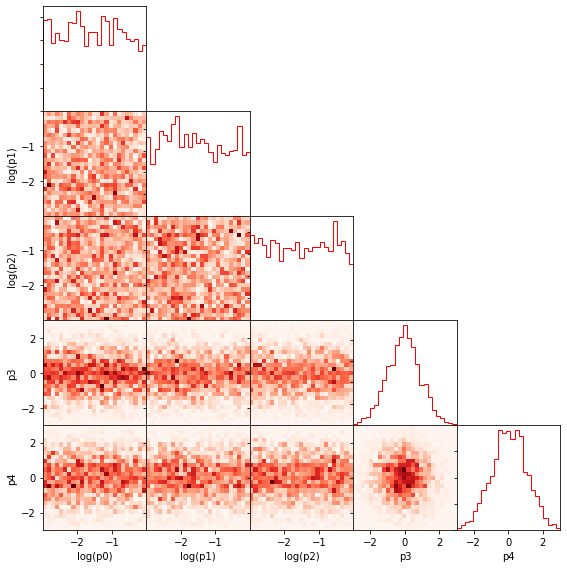

In [3]:
from anesthetic.plot import hist_plot_1d, hist_plot_2d

def plotter(theta, names, w=None, ndims=5):
    """ Helper function that uses anesthetic to produce corner plots """
    fig, axes = plt.subplots(ndims, ndims, figsize=(8, 8), sharex='col')
    for i in range(ndims):
        for j in range(ndims):
            if i < j:
                axes[i, j].axis('off')
            if i == j:
                hist_plot_1d(axes[i, j], theta[:, i], weights=w,
                xmin=theta[:, i].min(), xmax=theta[:, i].max(), color='r',
                histtype='step', bins=25, density=True)
            if i < j:
                hist_plot_2d(axes[j, i], theta[:, i], theta[:, j],
                            weights=w,
                            xmin=theta[:, i].min(), xmax=theta[:, i].max(),
                            ymin=theta[:, j].min(), ymax=theta[:, j].max(),
                            bins=25, density=True, cmap=plt.get_cmap('Reds'))
            if j not in set([0, ndims]):
                axes[i, j].set_yticklabels([])
            if j == 0:
                if i == 0:
                    axes[i, j].set_yticklabels([])
                else:
                    axes[i, j].set_ylabel(names[i])
            if i == ndims-1:
                axes[i, j].set_xlabel(names[j])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

names = ['log(p' + str(i) + ')' if i in [0, 1, 2] else 'p' + str(i) for i in range(ndims)]
plotter(theta, names, weights)

## Masked Autoregressive Flows

Firstly we will look at training a Masked Autoregressive Flow or MAF with `bayesstats`. To train the MAF we first need to initalise the class with the samples and corresponding weights.

In [4]:
import os
os.chdir('../')

from bayesstats.maf import MAF

bij = MAF(theta, weights)
bij.train(100)

Epoch: 0 Loss: 0.0015970782
Epoch: 1 Loss: 0.0014518229
Epoch: 2 Loss: 0.0013889455
Epoch: 3 Loss: 0.0013541076
Epoch: 4 Loss: 0.0013303773
Epoch: 5 Loss: 0.001311938
Epoch: 6 Loss: 0.0012964931
Epoch: 7 Loss: 0.001282999
Epoch: 8 Loss: 0.0012709134
Epoch: 9 Loss: 0.0012599197
Epoch: 10 Loss: 0.0012498101
Epoch: 11 Loss: 0.0012404328
Epoch: 12 Loss: 0.001231667
Epoch: 13 Loss: 0.0012234113
Epoch: 14 Loss: 0.0012155833
Epoch: 15 Loss: 0.001208124
Epoch: 16 Loss: 0.0012010036
Epoch: 17 Loss: 0.0011942239
Epoch: 18 Loss: 0.0011878129
Epoch: 19 Loss: 0.0011818134
Epoch: 20 Loss: 0.001176266
Epoch: 21 Loss: 0.0011711912
Epoch: 22 Loss: 0.0011665784
Epoch: 23 Loss: 0.0011623907
Epoch: 24 Loss: 0.0011585806
Epoch: 25 Loss: 0.001155119
Epoch: 26 Loss: 0.00115201
Epoch: 27 Loss: 0.001149292
Epoch: 28 Loss: 0.0011470171
Epoch: 29 Loss: 0.0011452205
Epoch: 30 Loss: 0.0011438965
Epoch: 31 Loss: 0.0011429894
Epoch: 32 Loss: 0.0011424024
Epoch: 33 Loss: 0.0011420209
Epoch: 34 Loss: 0.0011417371
Epoc

We can then generate samples from the bijector using the following code which technically takes samples on the hypercube and transforms them into samples on the target posterior distribution,

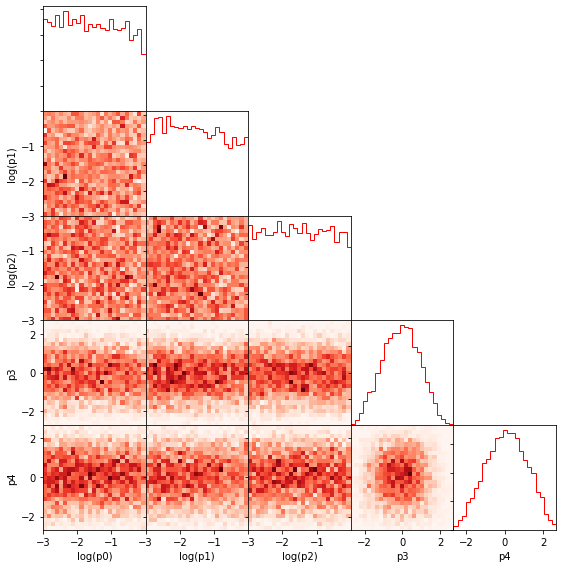

In [5]:
x = bij(np.random.uniform(0, 1, size=(len(theta), theta.shape[-1])))

plotter(x, names)

Alternatively we can generate samples with the following code which takes in an integer and returns an array of shape (int, 5). The `.sample()` function is a proxy for `__call__`.

In [6]:
x = bij.sample(5000)

We can then go ahead an calculate the corresponding kl divergence and Bayesian dimensionality. 

The samples presented here were generated using a gaussian likelihood and fitting with nested sampling for 5 parameters. We can use `anesthetic` to calculate the KL divergence and Bayesian dimensionality for the samples for comparison. We see very similar results and note that the similarity improves with the number of epochs.

In [7]:
from bayesstats.marginal_stats import maf_calculations

stats = maf_calculations(bij, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

tf.Tensor(0.7561633, shape=(), dtype=float32) 0.7628134849726684
tf.Tensor(1.3143787, shape=(), dtype=float32) 1.7759303343302957


We could imagine that the above set of parameters is a sub-sample of perhaps signal parameters that we are interested in and having marginalised out the nuisance parameters we can use `bayesstats` to determine how well constrained the sub-space is.

As an example we can train a MAF on three of the parameters in this distribution.

Epoch: 0 Loss: 0.0009195127
Epoch: 1 Loss: 0.00084214786
Epoch: 2 Loss: 0.0008125184
Epoch: 3 Loss: 0.00079769804
Epoch: 4 Loss: 0.0007880553
Epoch: 5 Loss: 0.0007804098
Epoch: 6 Loss: 0.00077353755
Epoch: 7 Loss: 0.000766883
Epoch: 8 Loss: 0.00076018996
Epoch: 9 Loss: 0.0007534042
Epoch: 10 Loss: 0.0007466396
Epoch: 11 Loss: 0.00074014236
Epoch: 12 Loss: 0.00073424244
Epoch: 13 Loss: 0.0007292858
Epoch: 14 Loss: 0.00072554714
Epoch: 15 Loss: 0.0007231117
Epoch: 16 Loss: 0.00072176696
Epoch: 17 Loss: 0.0007210066
Epoch: 18 Loss: 0.00072023284
Epoch: 19 Loss: 0.0007190538
Epoch: 20 Loss: 0.000717445
Epoch: 21 Loss: 0.000715663
Epoch: 22 Loss: 0.0007140167
Epoch: 23 Loss: 0.0007126663
Epoch: 24 Loss: 0.00071157113
Epoch: 25 Loss: 0.00071059127
Epoch: 26 Loss: 0.0007096432
Epoch: 27 Loss: 0.0007087707
Epoch: 28 Loss: 0.00070809165
Epoch: 29 Loss: 0.00070768746
Epoch: 30 Loss: 0.00070753216
Epoch: 31 Loss: 0.00070750515
Epoch: 32 Loss: 0.00070746674
Epoch: 33 Loss: 0.0007073351
Epoch: 34 L

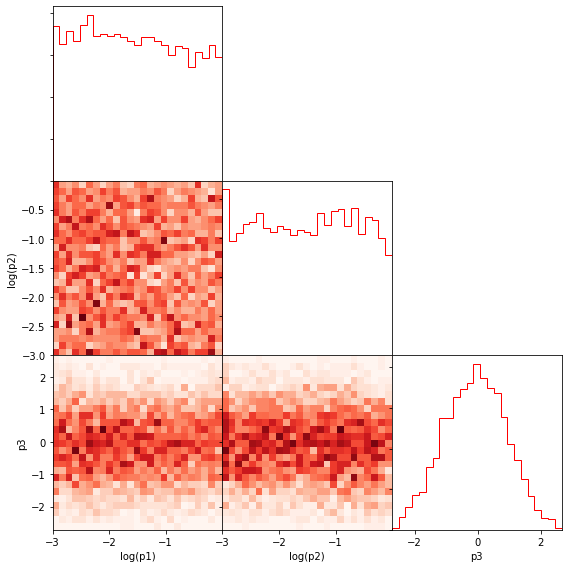

tf.Tensor(0.41076437, shape=(), dtype=float32)
tf.Tensor(0.77010304, shape=(), dtype=float32)


In [8]:
theta_reduced = theta[:, 1:-1]
names_reduced = names[1:-1]

bij = MAF(theta_reduced, weights)
bij.train(100)
x = bij.sample(5000)

plotter(x, names_reduced, ndims=3)

stats = maf_calculations(bij, x)
print(stats.klDiv())
print(stats.bayesian_dimensionality())

# Kernel Density Estimators

We can perform a similar analysis using Kernel Density Estimators rather than MAFs which is done with the following code. Note that the generation of the 'trained' model is significantly quicker than when performed with the MAFs.

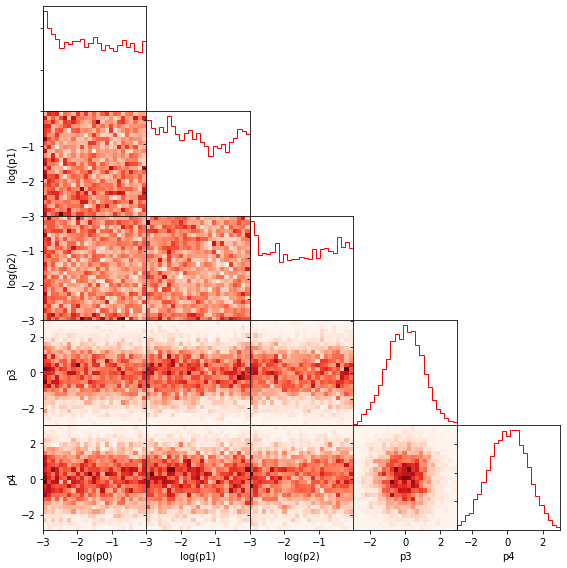

tf.Tensor(0.8281729, shape=(), dtype=float32) 0.7628134849726684
tf.Tensor(1.7893331, shape=(), dtype=float32) 1.7759303343302957


In [9]:
from bayesstats.kde import KDE
kde = KDE(theta, weights)
kde.generate_kde()
x = kde.sample(5000)

plotter(x, names)

from bayesstats.marginal_stats import kde_calculations

stats = kde_calculations(kde, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

Rather than using the `kde.sample()` function to generate samples we could transform samples from the hypercube with the following code. However, we note that this is a much slower method of generating samples as it is designed to be bijective. Transformation from the hypercube is useful if we would like to use a trained KDE or MAF as the prior in a subseqeunt nested sampling run however is not necissary if we simply want to calcualte marginal Bayesian statistics.

In [12]:
x = kde(np.random.uniform(0, 1, size=(10, theta.shape[-1])))
print(x)

[[-0.70678295 -2.92661438 -2.15884215 -0.25256686 -0.1032339 ]
 [-2.40161305 -2.5541544  -2.44247203 -1.0244403   0.68400483]
 [-2.90485132 -0.76886809 -2.29264263 -0.36240851  0.40278625]
 [-0.24707256 -0.51681385 -1.8166892  -0.64972108 -0.83132431]
 [-2.35465953 -2.98118285 -2.53109752  0.36386813  0.74911994]
 [-1.67527823 -2.97513448 -1.16409405 -0.74443368 -0.45681731]
 [-2.35423764 -1.802828   -1.4850102  -0.22781295  0.68045671]
 [-2.11597495 -0.63880557 -1.68669428 -0.41141343  1.19492162]
 [-2.98582996 -2.8513691  -1.01533019  1.17565323  0.19444828]
 [-1.07779061 -2.32937741 -0.53094474 -0.75321943  0.57310924]]
